In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit.quantum_info import DensityMatrix

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

In [3]:
from qCircuit import createInputCircuit, createModelCircuit, createNoisyModelCircuit
from qLipschitz import QLipschitz
from qDistance import d, D

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Step 1 prepare data

In [5]:
X_train, Y_train = datasets.make_circles(n_samples=500, noise=0.09, factor=0.4)
X_test, Y_test = datasets.make_circles(n_samples=200, noise=0.09, factor=0.4)

### - 1.1 Plot origin data

In [6]:
print('Training Data:')
print(X_train[:10])
print('\nTraining Label:')
print(Y_train[:10])

Training Data:
[[ 1.02365429 -0.21965311]
 [-0.74054051 -0.85464588]
 [-1.00555393 -0.17267907]
 [ 0.83147506 -0.60641767]
 [-0.8624401  -0.15794606]
 [ 0.04495771 -1.09399492]
 [ 0.00241018  1.05225398]
 [ 0.50322294 -0.148569  ]
 [ 0.72022811 -0.66375493]
 [-0.14979968 -0.37359155]]

Training Label:
[0 0 0 0 0 0 0 1 0 1]


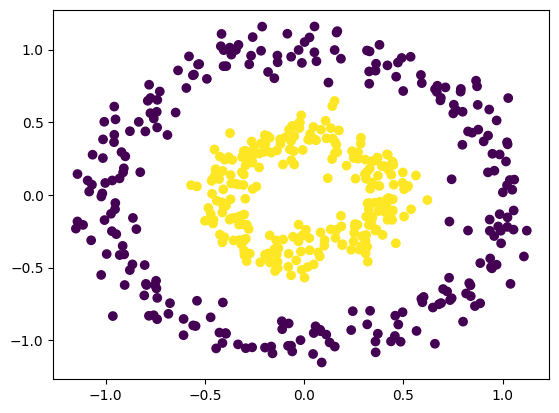

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.show()

In [8]:
print(f'Total datas: {len(X_train)}')
print(f'labels: {list(set(Y_train))}')
print(f' - label 0 datas: {len(list(filter(lambda x: x==0, Y_train)))}')
print(f' - label 1 datas: {len(list(filter(lambda x: x==1, Y_train)))}')

Total datas: 500
labels: [0, 1]
 - label 0 datas: 250
 - label 1 datas: 250


### - 1.2 Add new dimention datas

In [9]:
Z_train = (X_train[:, 0] ** 2 + X_train[:, 1] ** 2) ** 0.5
temp = np.zeros((X_train.shape[0], len(X_train[0]) + 1))
temp[:, :-1] = X_train
temp[:, -1] = Z_train
X_train2 = temp

Z_test = (X_test[:, 0] ** 2 + X_test[:, 1] ** 2) ** 0.5
temp = np.zeros((X_test.shape[0], len(X_test[0]) + 1))
temp[:, :-1] = X_test
temp[:, -1] = Z_test
X_test2 = temp

print('Solved Training Data:')
print(X_train2[:10])

Solved Training Data:
[[ 1.02365429 -0.21965311  1.04695539]
 [-0.74054051 -0.85464588  1.13084916]
 [-1.00555393 -0.17267907  1.02027289]
 [ 0.83147506 -0.60641767  1.02912252]
 [-0.8624401  -0.15794606  0.87678383]
 [ 0.04495771 -1.09399492  1.0949183 ]
 [ 0.00241018  1.05225398  1.05225674]
 [ 0.50322294 -0.148569    0.52469617]
 [ 0.72022811 -0.66375493  0.97943818]
 [-0.14979968 -0.37359155  0.40250539]]


### - 1.3 plot in 3D coordinate system

In [10]:
def plot3D(X, Y):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        X[:, 0], X[:, 1], X[:, 2], 
        zdir='z', s=30, c=Y, depthshade=True
    )
    plt.show()

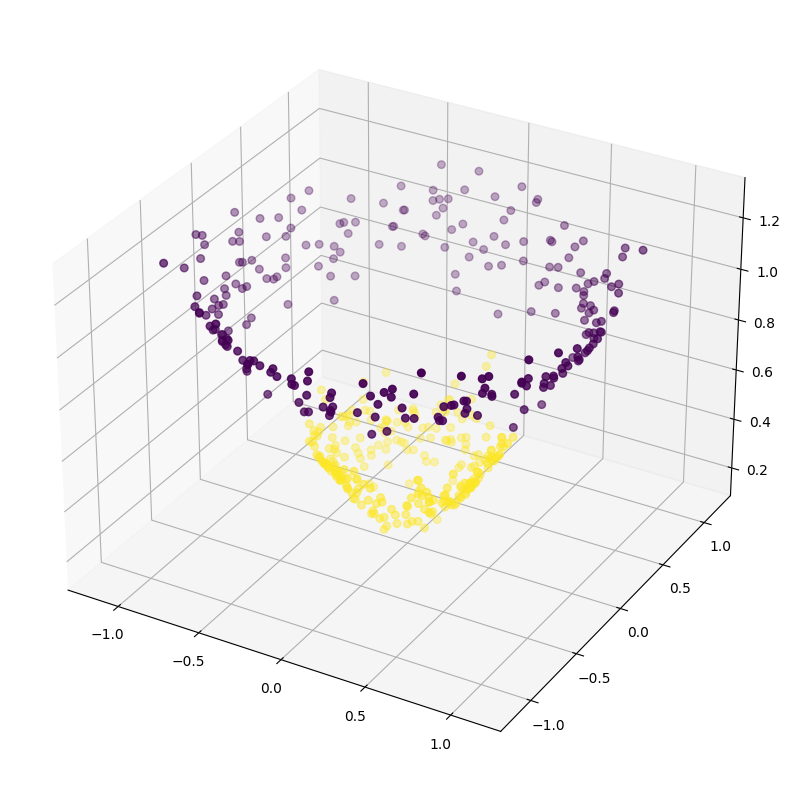

In [11]:
plot3D(X_train2, Y_train)

### - 1.4 load iris data

In [12]:
X, Y = datasets.load_iris(return_X_y=True)

X_train_0 = X[0:30]
X_train_1 = X[50:80]
X_train_iris = np.vstack((X_train_0, X_train_1))

Y_train_0 = Y[0:30]
Y_train_1 = Y[50:80]
Y_train_iris = np.vstack((Y_train_0, Y_train_1)).flatten()

X, Y = datasets.load_iris(return_X_y=True)

X_test_0 = X[30:50]
X_test_1 = X[80:100]
X_test_iris = np.vstack((X_test_0, X_test_1))

Y_test_0 = Y[30:50]
Y_test_1 = Y[80:100]
Y_test_iris = np.vstack((Y_test_0, Y_test_1)).flatten()

In [13]:
X_train_iris = (X_train_iris - X_train_iris.min(axis=0)) / (X_train_iris.max(axis=0) - X_train_iris.min(axis=0))
X_test_iris = (X_test_iris - X_test_iris.min(axis=0)) / (X_test_iris.max(axis=0) - X_test_iris.min(axis=0))

## Step 2 Initialize Quantum Circuit

In [14]:
import qiskit
from qiskit import Aer, execute

qasm_backend = Aer.get_backend('qasm_simulator')

In [15]:
params = [
    [[-1.18991246e-01, -8.69694713e-01,  1.43722811e-03],
      [ 3.47641545e+00, -4.73632073e-02,  1.97135609e+00],
      [ 1.95775707e+00, -1.12139160e-02, -6.21796144e-03]],

     [[ 2.02460380e-02, -2.25797547e+00,  5.14234265e-03],
      [-1.71552299e-02,  2.46283604e-03, -1.03805722e-02],
      [-2.37244982e-03, -3.35799404e-03,  6.10191152e-03]]
]

params_iris = [
    [[-3.42142600e-02, -5.45047534e-03,  8.11905347e-01],
     [-1.52484152e+00,  1.49884676e+00, -1.25408626e-02],
     [-1.89515860e-03,  1.35760410e-02,  8.22999582e-03],
     [ 1.39102114e+00,  4.19729865e-01,  1.60000380e-04]],

    [[ 7.88431068e-01, -8.86177264e-01,  1.33830291e-02],
     [-3.71228143e-03, -1.12994101e-02, -1.27897783e-02],
     [ 9.45954683e-03, -3.34659883e-03,  1.17217829e-02],
     [ 1.98256181e-02, -1.07358054e-02,  7.53621360e-03]]
]

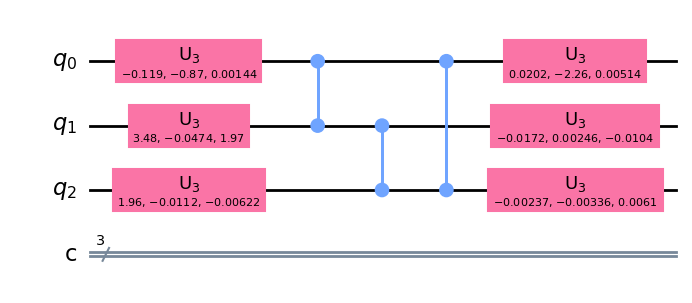

In [16]:
# Test 1: createModelCircuit
createModelCircuit(params).draw(output='mpl')

### - 2.2 evaluate

In [17]:
def predict(model, data):
    qubits_num = len(data)
    input_circuit = createInputCircuit(data)
    qcircuit = input_circuit.compose(model)
    
    # the measurement
    qcircuit.measure(list(range(qubits_num)), list(range(qubits_num)))

    # job execution
    shots = 1000
    job_sim = execute(qcircuit, qasm_backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qcircuit)

    p1 = 0
    for i in range(2 ** (qubits_num - 1)):
        comb = str(bin(i + 2 ** (qubits_num - 1))[2:])
        p1 += counts.get(comb, 0)
        
    p1 /= shots
    
    if p1 > 0.5:
        return 1
    else:
        return 0

In [18]:
def accuracy(model, datas, labels):
    predictions = [ predict(model, data) for data in datas ]
    
    acc = 0
    for i, p in enumerate(predictions):
        if p == labels[i]:
            acc += 1
    
    return acc / len(predictions)

In [19]:
def evaluate(model, X_test, Y_test):
    acc = accuracy(model, X_test, Y_test)

    print("FINAL ACCURACY: {:0.2f}%".format(acc * 100))

In [20]:
# Test 2: evaluate noiseless model

test2_circuit = createModelCircuit(params_iris)

evaluate(test2_circuit, X_train_iris, Y_train_iris)
evaluate(test2_circuit, X_test_iris, Y_test_iris)

FINAL ACCURACY: 98.33%
FINAL ACCURACY: 100.00%


## Step 3 Create Noisy Circuit

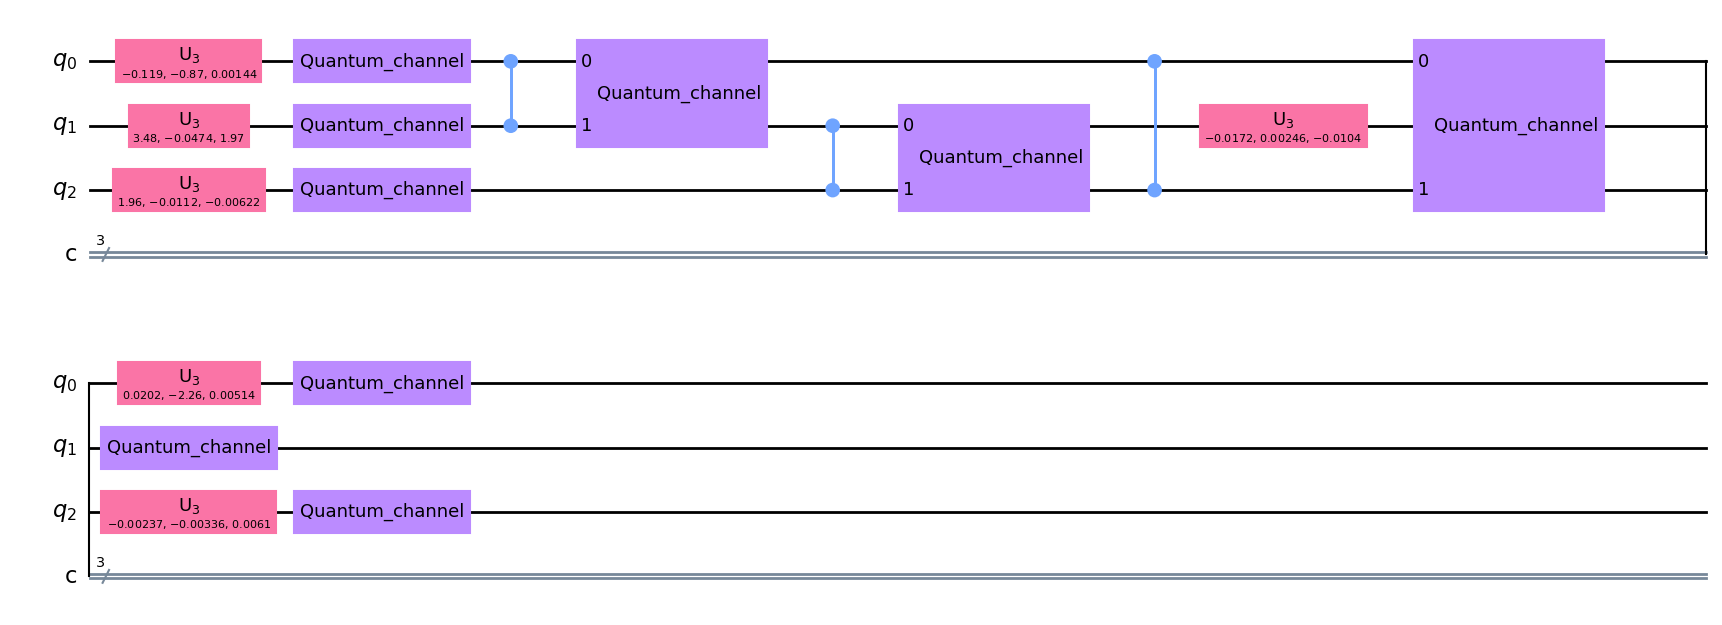

In [21]:
# Test 3: create noisy model circuit - circle

test3_p = 0.001
test3_circuit = createNoisyModelCircuit(params, test3_p, 'phase_flip')
test3_circuit.draw(output='mpl')

In [22]:
# Test 4: evaluate noisy model - circle

test4_p = 0.001
models_type = [
    'noiseless', 'bit_flip', 'phase_flip', 'depolarizing'
]
test4_circuits = [
    createModelCircuit(params),
    createNoisyModelCircuit(params, test4_p, 'bit_flip'),
    createNoisyModelCircuit(params, test4_p, 'phase_flip'),
    createNoisyModelCircuit(params, test4_p, 'depolarizing')
]

for i, model_type in enumerate(models_type):
    print(f'Evaluate <{model_type}>: ')
    evaluate(test4_circuits[i], X_test2, Y_test)
    print()

Evaluate <noiseless>: 
FINAL ACCURACY: 94.00%

Evaluate <bit_flip>: 
FINAL ACCURACY: 92.00%

Evaluate <phase_flip>: 
FINAL ACCURACY: 92.00%

Evaluate <depolarizing>: 
FINAL ACCURACY: 92.00%



## Step 4 Calculate Lipschitz constant

### - 4.1 calculate lipschitz constant

In [23]:
# Test 5: calculate lipschitz constant

print('Classifier for centric circle: ')
test5_1_circuit = createModelCircuit(params)
test5_1_qlipschitz = QLipschitz(test5_1_circuit, [0, 1])
print(test5_1_qlipschitz.constant)

print('\nClassifier for Iris: ')
test5_2_circuit = createModelCircuit(params_iris)
test5_2_qlipschitz = QLipschitz(test5_2_circuit, [0, 1])
print(test5_2_qlipschitz.constant)

Classifier for centric circle: 
(1.0, array([[ 0.08830713+0.j        ,  0.0052315 -0.00061151j,
        -0.54784316+0.03141748j,  0.03646262+0.00281407j,
         0.14485073-0.00194239j, -0.00875763-0.001208j  ,
         0.8147165 -0.05454154j,  0.04297415-0.00832087j],
       [ 0.5483868 +0.j        ,  0.03865225+0.00100061j,
        -0.13613315+0.11122154j,  0.00441891+0.13853304j,
        -0.7345542 +0.26197848j, -0.09349396+0.03739827j,
        -0.03322783+0.0185454j ,  0.1658317 +0.01931279j]],
      dtype=complex64))

Classifier for Iris: 
(1.0, array([[ 5.1224810e-01+0.0000000e+00j,  1.2805447e-01-1.5716428e-01j,
        -4.6464182e-02-4.8011953e-01j, -1.7507088e-01-1.1697307e-01j,
         1.9302657e-03-2.3970471e-05j,  4.7483321e-04-5.9813249e-04j,
        -2.5687154e-04-2.7331561e-03j, -9.9440350e-04-6.6813920e-04j,
         3.9289543e-01+1.7302768e-01j,  1.6676332e-01-8.4787413e-02j,
         1.3040526e-01-3.9493093e-01j, -8.8753097e-02-1.3898401e-01j,
         2.2194656e-03

In [24]:
# Test 6-1: calculate lipschitz constant in noisy model

test6_p = [0.0001, 0.001, 0.05, 0.1]
models_type = [
    'noiseless', 'bit_flip', 'phase_flip', 'depolarizing'
]

print('Classifier for centric circle: ')
for p in test6_p:
    test6_1_circuits = [
        createModelCircuit(params),
        createNoisyModelCircuit(params, p, 'bit_flip'),
        createNoisyModelCircuit(params, p, 'phase_flip'),
        createNoisyModelCircuit(params, p, 'depolarizing')
    ]
    
    print(f'p: {p}')
    for i, model_type in enumerate(models_type):
        test6_1_qlipschitz = QLipschitz(test6_1_circuits[i], [0, 1])
        print(f'{model_type} model: {test6_1_qlipschitz.constant[0]}')
    print()

Classifier for centric circle: 
p: 0.0001
noiseless model: 1.0
bit_flip model: 0.9982796311378479
phase_flip model: 0.9992163777351379
depolarizing model: 0.9989377856254578

p: 0.001
noiseless model: 1.0
bit_flip model: 0.9829362034797668
phase_flip model: 0.9922083020210266
depolarizing model: 0.9894289970397949

p: 0.05
noiseless model: 1.0
bit_flip model: 0.43096035718917847
phase_flip model: 0.709731936454773
depolarizing model: 0.5891456604003906

p: 0.1
noiseless model: 1.0
bit_flip model: 0.19194786250591278
phase_flip model: 0.5588558912277222
depolarizing model: 0.35014522075653076



In [25]:
# Test 6-2: calculate lipschitz constant in noisy model

test6_p = [0.0001, 0.001, 0.05, 0.1]
models_type = [
    'noiseless', 'bit_flip', 'phase_flip', 'depolarizing'
]

print('Classifier for Iris: ')
for p in test6_p:
    test6_2_circuits = [
        createModelCircuit(params_iris),
        createNoisyModelCircuit(params_iris, p, 'bit_flip'),
        createNoisyModelCircuit(params_iris, p, 'phase_flip'),
        createNoisyModelCircuit(params_iris, p, 'depolarizing')
    ]
    
    print(f'p: {p}')
    for i, model_type in enumerate(models_type):
        test6_2_qlipschitz = QLipschitz(test6_2_circuits[i], [0, 1])
        print(f'{model_type} model: {test6_2_qlipschitz.constant[0]}')
    print()

Classifier for Iris: 
p: 0.0001
noiseless model: 1.0
bit_flip model: 0.9974957704544067
phase_flip model: 0.9983262419700623
depolarizing model: 0.9986007213592529

p: 0.001
noiseless model: 1.0
bit_flip model: 0.975249707698822
phase_flip model: 0.9834035038948059
depolarizing model: 0.9860955476760864

p: 0.05
noiseless model: 1.0
bit_flip model: 0.29632073640823364
phase_flip model: 0.4548749029636383
depolarizing model: 0.4973519444465637

p: 0.1
noiseless model: 1.0
bit_flip model: 0.09604907780885696
phase_flip model: 0.23411400616168976
depolarizing model: 0.249342143535614



### - 4.2 Fairness verifying

#### - 4.2.1 find proper epsilon

In [26]:
# Test 7-1: find proper epsilon - circle

import random

# D(rou, sigma) <= epsilon
indices = []
while len(indices) < 50:
    a = random.randint(0, len(X_train2) - 1)
    b = random.randint(0, len(X_train2) - 1)
    if a != b:
        indices.append([a, b])

distances = []
for pair in indices:
    rou = getDensityMatrix(createInputCircuit(X_train2[pair[0]]))
    sigma = getDensityMatrix(createInputCircuit(X_train2[pair[1]]))
    
    distances.append(D(rou, sigma))
    
print('find proper epsilon - centric circle')
print(f'Mean distance: {sum(distances) / len(distances)}')
print(f'Max distance: {max(distances)}')
print(f'Min distance: {min(distances)}')

find proper epsilon - centric circle
Mean distance: 0.8446689116174345
Max distance: 1.0000000085439371
Min distance: 0.14450173011367712


In [27]:
# Test 7-2: find proper epsilon - iris

# D(rou, sigma) <= epsilon
indices = []
while len(indices) < 50:
    a = random.randint(0, len(X_train_iris) - 1)
    b = random.randint(0, len(X_train_iris) - 1)
    if a != b:
        indices.append([a, b])

distances = []
for pair in indices:
    rou = getDensityMatrix(createInputCircuit(X_train_iris[pair[0]]))
    sigma = getDensityMatrix(createInputCircuit(X_train_iris[pair[1]]))
    
    distances.append(D(rou, sigma))

print('find proper epsilon - centric iris')
print(f'Mean distance: {sum(distances) / len(distances)}')
print(f'Max distance: {max(distances)}')
print(f'Min distance: {min(distances)}')

find proper epsilon - centric iris
Mean distance: 0.7930522500030969
Max distance: 0.9999049328843599
Min distance: 0.1790409864946439


#### - 4.2.2 find proper delta

In [28]:
# Test 8-1: find proper delta - circle

test8_1_circuit = createModelCircuit(params)
test8_1_qlipschitz = QLipschitz(test8_1_circuit, [0, 1])
test8_1_A = test8_1_qlipschitz.A

# d(A(rou), A(sigma)) <= delta
indices = []
while len(indices) < 50:
    a = random.randint(0, len(X_train2) - 1)
    b = random.randint(0, len(X_train2) - 1)
    if a != b:
        indices.append([a, b])

distances = []
for pair in indices:
    rou = getDensityMatrix(createInputCircuit(X_train2[pair[0]]))
    sigma = getDensityMatrix(createInputCircuit(X_train2[pair[1]]))
    
    distances.append(d(test8_1_A, rou, sigma))

print('find proper delta - circle')
print(f'Mean distance: {sum(distances) / len(distances)}')
print(f'Max distance: {max(distances)}')
print(f'Min distance: {min(distances)}')

find proper delta - circle
Mean distance: 0.08788685781439862
Max distance: 0.3224368123208829
Min distance: 0.0004491843477905355


In [30]:
# Test 8-2: find proper delta - circle

test8_2_circuit = createModelCircuit(params_iris)
test8_2_qlipschitz = QLipschitz(test8_2_circuit, [0, 1])
test8_2_A = test8_2_qlipschitz.A

# d(A(rou), A(sigma)) <= delta
indices = []
while len(indices) < 50:
    a = random.randint(0, len(X_train_iris) - 1)
    b = random.randint(0, len(X_train_iris) - 1)
    if a != b:
        indices.append([a, b])

distances = []
for pair in indices:
    rou = getDensityMatrix(createInputCircuit(X_train_iris[pair[0]]))
    sigma = getDensityMatrix(createInputCircuit(X_train_iris[pair[1]]))
    
    distances.append(d(test8_2_A, rou, sigma))

print('find proper delta - iris')
print(f'Mean distance: {sum(distances) / len(distances)}')
print(f'Max distance: {max(distances)}')
print(f'Min distance: {min(distances)}')

find proper delta - iris
Mean distance: 0.13329026509783037
Max distance: 0.2593547953308662
Min distance: 0.0010379219391733335


#### - 4.2.3 fairness verifying

In [31]:
# Test 9-1: fairness verifying - circle

test9_1_circuit = createNoisyModelCircuit(params, p=0.001, errorType='bit_flip')
test9_1_qlipschitz = QLipschitz(test9_1_circuit, [0, 1])
print(f'Lipschitz constant: {test9_1_qlipschitz.constant[0]}\n')

test9_1_fairness_params = [
    # epsilon, delta
    [1, 1], [0.9, 0.89], [0.6, 0.58], [0.6, 0.59]
]

for epsilon, delta in test9_1_fairness_params:
    flag, kernel = test9_1_qlipschitz.fairVeriQ(epsilon, delta)
    
    print(f'A is ({epsilon},{delta})-fair: <{flag}>')
    if not flag:
        print(f' - bias kernel pair is: {kernel}')
    print()

Lipschitz constant: 0.9829362034797668

A is (1,1)-fair: <True>

A is (0.9,0.89)-fair: <True>

A is (0.6,0.58)-fair: <False>
 - bias kernel pair is: [[ 8.7966137e-02+0.j          5.2421880e-03-0.00060624j
  -5.4890203e-01+0.03147535j  3.6392592e-02+0.00287853j
   1.4496601e-01-0.00197145j -8.7222224e-03-0.00120635j
   8.1403214e-01-0.05442044j  4.2936157e-02-0.00820159j]
 [ 5.2705202e-02+0.j          8.3077484e-01+0.12186631j
   5.6519429e-04-0.00089926j  1.2709215e-01+0.01143511j
  -2.9756736e-02-0.00739511j  5.1050264e-01+0.07122577j
  -3.7684434e-04+0.00077956j -9.5929116e-02-0.0083804j ]]

A is (0.6,0.59)-fair: <True>



In [33]:
# Test 9-2: fairness verifying - iris

test9_2_circuit = createNoisyModelCircuit(params_iris, p=0.001, errorType='phase_flip')
test9_2_qlipschitz = QLipschitz(test9_2_circuit, [0, 1])
print(f'Lipschitz constant: {test9_2_qlipschitz.constant[0]}\n')

test9_2_fairness_params = [
    # epsilon, delta
    [1, 0.99], [0.8, 0.79], [0.5, 0.3]
]

for epsilon, delta in test9_2_fairness_params:
    flag, kernel = test9_1_qlipschitz.fairVeriQ(epsilon, delta)
    
    print(f'A is ({epsilon},{delta})-fair: <{flag}>')
    if not flag:
        print(f' - bias kernel pair is: {kernel}')
    print()

Lipschitz constant: 0.9834035038948059

A is (1,0.99)-fair: <True>

A is (0.8,0.79)-fair: <True>

A is (0.5,0.3)-fair: <False>
 - bias kernel pair is: [[ 8.7966137e-02+0.j          5.2421880e-03-0.00060624j
  -5.4890203e-01+0.03147535j  3.6392592e-02+0.00287853j
   1.4496601e-01-0.00197145j -8.7222224e-03-0.00120635j
   8.1403214e-01-0.05442044j  4.2936157e-02-0.00820159j]
 [ 5.2705202e-02+0.j          8.3077484e-01+0.12186631j
   5.6519429e-04-0.00089926j  1.2709215e-01+0.01143511j
  -2.9756736e-02-0.00739511j  5.1050264e-01+0.07122577j
  -3.7684434e-04+0.00077956j -9.5929116e-02-0.0083804j ]]



### - 4.3 Generate Bias pair

In [34]:
# Test 10: generate bias pair

test10_circuit = createNoisyModelCircuit(params_iris, p=0.01, errorType='depolarizing')
test10_qlipschitz = QLipschitz(test10_circuit, [0, 1])

print(f'Lipschitz constant: {test10_qlipschitz.constant[0]}\n')

flag, kernel = test10_qlipschitz.fairVeriQ(epsilon=0.9, delta=0.3)
print(f'fairness: {flag}')
assert (not flag)

test10_sigma = getDensityMatrix(createInputCircuit(X_train_iris[11]))
test10_bias_pair = test10_qlipschitz.generateBiasPair(test10_sigma, kernel, epsilon=0.9)
test10_rou_psi, test10_rou_phi = test10_bias_pair
# print(test10_bias_pair)

print(f'epsilon=0.9, delta=0.3')
print('D: ', D(test10_rou_psi, test10_rou_phi))
print('d: ', d(test10_qlipschitz.A, test10_rou_psi, test10_rou_phi))

Lipschitz constant: 0.8693678379058838

fairness: False
epsilon=0.9, delta=0.3
D:  0.9000000232731683
d:  0.39121552565082224
